# **Animal Competition (30%)**

In [1]:
##################################################################################################################################
### Subject: Computer Vision 
### Year: 2022
### Student Name: Ishan Honhaga, Ankit Panda
### Student ID: a1834222, a18150362
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 94.68         FLOPs: 0.96G
##################################################################################################################################

In [2]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Mounting G-Drive to get your dataset. 
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU. 
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/dataset/dataset/dataset/'
classes = os.listdir(data_dir)

Mounted at /content/drive


In [4]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...

def getTransformer(type_transformer):
  data_transform = None
  if(type_transformer == 'baseline'):
    data_transform =  transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])
  elif(type_transformer == 'baseline_modification'):
    data_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomVerticalFlip(), #Added RandomVerticalFlip()
            transforms.RandomAdjustSharpness(2), #Added RandomAdjustSharpness()
            transforms.RandomAutocontrast(), #Added RandomAutocontrast()
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)), #Check for Normalize weights
        ])
  elif(type_transformer =='ResNet'):
    #Tranforms from as used in ResNET18
    resnet_18_weights = models.ResNet18_Weights.DEFAULT
    data_transform = resnet_18_weights.transforms()
    
  return data_transform

In [5]:
# Checking the dataset training size.
def getDataset(data_dir, transformer, showImg = True):
  dataset = ImageFolder(data_dir, transform=transformer)
  print('Size of training dataset :', len(dataset))
  #Printing Size of one image Shape
  img, label = dataset[100]
  print('Shape of an Image is ', img.shape)
  return dataset

In [6]:
# Preview one of the images..
def show_image(dataset, index = 200):
    img, label = dataset[index]
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

In [7]:
# show_image(dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10) 
def splitDataset(dataset):
  val_size = len(dataset)//20
  test_size = len(dataset)//10
  train_size = len(dataset) - val_size - test_size
  
  # Random Splitting. 
  train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
  len(train_ds), len(val_ds),len(test_ds)  
  return train_ds, val_ds, test_ds


In [9]:
def dataLoader(train_ds, val_ds, test_ds, batch_size = 16):
  train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
  test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)
  return train_loader, val_loader, test_loader

In [10]:
# Multiple images preview. 
def showMultiplesImages(train_loader):
  for images, labels in train_loader:
      fig, ax = plt.subplots(figsize=(18,10))
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
      break
  return

In [11]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
        
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
def loadDataOnDevice(train_loader, val_loader, test_loader):
  train_loader = DeviceDataLoader(train_loader, device)
  val_loader = DeviceDataLoader(val_loader, device)
  test_loader = DeviceDataLoader(test_loader, device)
  return train_loader, val_loader, test_loader

In [14]:
input_size = 3*112*112
output_size = 151

In [15]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        
        return F.log_softmax(X, dim=1)

In [16]:
# Convolutional Network - Baseline_Dense
class ConvolutionalNetworkDense(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,3,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,256,3,1)
        self.conv4=nn.Conv2d(256,512,3,1, padding = 1)
        self.conv5=nn.Conv2d(512,256,3,1, padding = 1)
        self.conv6=nn.Conv2d(256,128,1,1, padding = 1)
        self.fc1= nn.Sequential(nn.Linear(128*2*2,128*2),nn.ReLU(),
                                nn.Linear(128*2,128),nn.ReLU(),
                                nn.Linear(128,self.num_classes))
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv5(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv6(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*2*2)
        X=self.fc1(X)
        return F.log_softmax(X, dim=1)        

In [17]:
# Convolutional Network - ResNet18
class ResNetPreTrainedNetwork(ImageClassificationBase):
    def __init__(self, classes, pretrained = True):
        super().__init__()
        self.model = models.resnet18(pretrained=pretrained)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, classes)
    def forward(self,X):
        return self.model(X)

In [18]:
# Model print
num_classes = 151
# ['baseline','baseline_modification','ResNet']
def getModel(type_model, preTrained = True):
  model = None
  if(type_model == 'baseline'):
    print('baseline')
    model = ConvolutionalNetwork(num_classes)
  elif(type_model == 'baseline_modification'):
    print('baseline_modification')
    model = ConvolutionalNetworkDense(num_classes) #UPDATE THE BASELINE CONNNET
  elif(type_model == 'ResNet'):
    print('ResNet')
    model = ResNetPreTrainedNetwork(num_classes, preTrained)
  model.cuda()
  return model

In [19]:
# We can check the input and the output shape
def checkInputOutputShape(model, train_loader):
  for images, labels in train_loader:
      out = model(images)
      print('images.shape:', images.shape)    
      print('out.shape:', out.shape)
      print('out[0]:', out[0])
      break
  return

In [20]:
# Functions for evaluation and training.
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

In [22]:
#For generating the same data in the splits
torch.manual_seed(10) 
#Initialising device
device = get_default_device()

In [23]:
def trainModel(model, train_loader, val_loader, opt_func, epoch, lr = 0.001):
  train_dl = DeviceDataLoader(train_loader, device)
  val_dl = DeviceDataLoader(val_loader, device)
  to_device(model, device)
  model = to_device(model, device)
  #Getting the accuracy of model on validation without any training
  print(f'Training with optimizer = {opt_func}, lr = {lr} and Epochs = {epoch}')
  history =[evaluate(model, val_loader)] 
  num_epochs = epoch
  history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
  return history

### 1. Baseline Performance

In [24]:
#Loading, processing and splitting Data
#Transformer
data_transformer = getTransformer('baseline')

#Loading and transforming Dataset
dataset =  getDataset(data_dir, data_transformer)

#Splitting Data
train_ds, val_ds, test_ds = splitDataset(dataset)

Size of training dataset : 6270
Shape of an Image is  torch.Size([3, 112, 112])


In [25]:
#Loading Data on device
train_loader, val_loader, test_loader = dataLoader(train_ds, val_ds, test_ds, batch_size = 16)
train_loader, val_loader, test_loader = loadDataOnDevice(train_loader, val_loader, test_loader)

baseline
Training with optimizer = <class 'torch.optim.adam.Adam'>, lr = 0.001 and Epochs = 10


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7768, val_loss: 4.5650, val_acc: 0.1142


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2008, val_loss: 4.2010, val_acc: 0.1698


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7370, val_loss: 3.9549, val_acc: 0.2826


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.2711, val_loss: 3.8810, val_acc: 0.3035


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.8158, val_loss: 3.8210, val_acc: 0.3653


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.4126, val_loss: 3.9649, val_acc: 0.3528


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.0651, val_loss: 4.3741, val_acc: 0.3865


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.7594, val_loss: 4.4037, val_acc: 0.3802


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.5386, val_loss: 4.8325, val_acc: 0.4115


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.2459, val_loss: 5.1033, val_acc: 0.3840


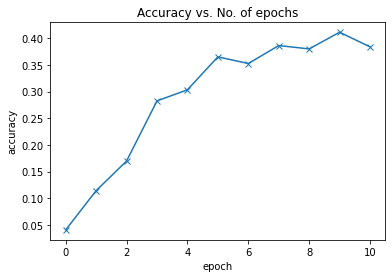

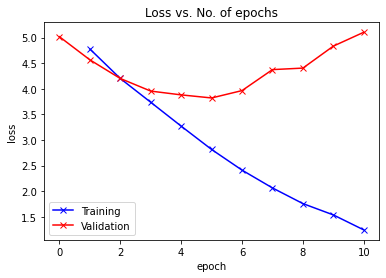


 Test Results, Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam


{'val_acc': 0.3609375059604645, 'val_loss': 5.054769039154053}

In [26]:
# Experiment Values: Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam
#Getting Model
model_baseline_epoch_10 = getModel('baseline')

#Training Model
history_baseline_epoch_10 = trainModel(model_baseline_epoch_10, train_loader = train_loader, val_loader = val_loader, 
                              opt_func = torch.optim.Adam, epoch = 10, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_baseline_epoch_10)
plot_losses(history_baseline_epoch_10)
print('\n Test Results, Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam') 
evaluate(model_baseline_epoch_10, test_loader)

baseline
Training with optimizer = <class 'torch.optim.adam.Adam'>, lr = 0.001 and Epochs = 30


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7758, val_loss: 4.4974, val_acc: 0.0969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.1706, val_loss: 4.1190, val_acc: 0.2073


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.6188, val_loss: 3.9360, val_acc: 0.3073


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.1803, val_loss: 3.8272, val_acc: 0.3278


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.7507, val_loss: 3.8366, val_acc: 0.3361


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.3729, val_loss: 4.0459, val_acc: 0.3729


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.9925, val_loss: 4.2385, val_acc: 0.3597


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.6580, val_loss: 4.4066, val_acc: 0.3785


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.3753, val_loss: 5.0397, val_acc: 0.3785


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1412, val_loss: 5.4253, val_acc: 0.3677


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.9186, val_loss: 5.9248, val_acc: 0.3802


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.7318, val_loss: 6.7836, val_acc: 0.3417


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6022, val_loss: 6.6186, val_acc: 0.3441


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5273, val_loss: 7.4722, val_acc: 0.3767


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4327, val_loss: 8.7211, val_acc: 0.3628


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.3697, val_loss: 8.6678, val_acc: 0.3646


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.3206, val_loss: 9.1856, val_acc: 0.3785


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.3212, val_loss: 8.7874, val_acc: 0.3597


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.2750, val_loss: 10.1118, val_acc: 0.3174


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.2312, val_loss: 10.9198, val_acc: 0.3590


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.2016, val_loss: 11.6195, val_acc: 0.3340


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.1751, val_loss: 12.6881, val_acc: 0.3434


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.2149, val_loss: 12.5413, val_acc: 0.3073


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.2024, val_loss: 13.2481, val_acc: 0.3340


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.2247, val_loss: 12.8450, val_acc: 0.3566


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.1881, val_loss: 12.1323, val_acc: 0.3465


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.1650, val_loss: 13.4155, val_acc: 0.3472


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.2547, val_loss: 11.2674, val_acc: 0.3441


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.1478, val_loss: 12.9593, val_acc: 0.3479


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.1937, val_loss: 12.8636, val_acc: 0.3465


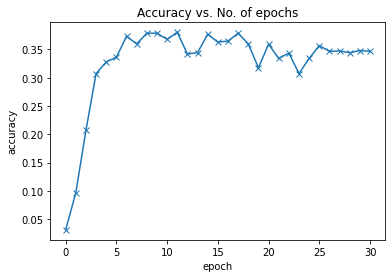

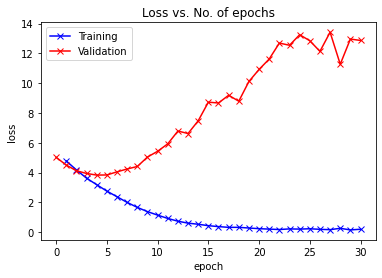


 Test Results, Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam


{'val_acc': 0.3427083492279053, 'val_loss': 12.814804077148438}

In [27]:
# Experiment Values: Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam
#Getting Model
model_baseline_epoch_30 = getModel('baseline') 

#Training Model
history_baseline_epoch_30 = trainModel(model_baseline_epoch_30, train_loader = train_loader, val_loader = val_loader, 
                              opt_func = torch.optim.Adam, epoch = 30, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_baseline_epoch_30)
plot_losses(history_baseline_epoch_30) 
print('\n Test Results, Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam')
evaluate(model_baseline_epoch_30, test_loader)

baseline
Training with optimizer = <class 'torch.optim.sgd.SGD'>, lr = 0.001 and Epochs = 10


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0178, val_loss: 5.0178, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 5.0138, val_loss: 5.0160, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 5.0095, val_loss: 5.0146, val_acc: 0.0250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 5.0047, val_loss: 5.0135, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9983, val_loss: 5.0113, val_acc: 0.0250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9895, val_loss: 5.0081, val_acc: 0.0219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9789, val_loss: 5.0069, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9672, val_loss: 5.0062, val_acc: 0.0094


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9570, val_loss: 4.9986, val_acc: 0.0094


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.9431, val_loss: 4.9866, val_acc: 0.0125


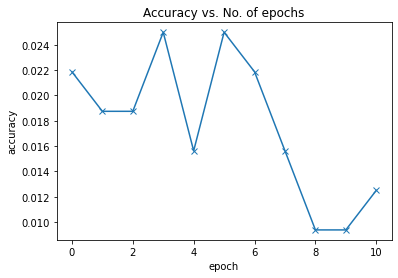

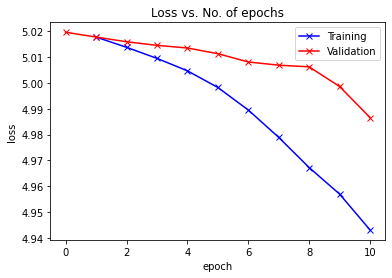


 Test Results, Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD


{'val_acc': 0.04062500223517418, 'val_loss': 4.973657131195068}

In [58]:
# Experiment Values: Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD
#Getting Model
model_baseline_SGD_epoch_10 = getModel('baseline')

#Training Model
history_baseline_SGD_epoch_10 = trainModel(model_baseline_SGD_epoch_10, train_loader = train_loader, val_loader = val_loader, 
                              opt_func = torch.optim.SGD, epoch = 10, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_baseline_SGD_epoch_10)
plot_losses(history_baseline_SGD_epoch_10)
print('\n Test Results, Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD') 
evaluate(model_baseline_SGD_epoch_10, test_loader)

baseline
Training with optimizer = <class 'torch.optim.sgd.SGD'>, lr = 0.001 and Epochs = 30


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0170, val_loss: 5.0147, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 5.0123, val_loss: 5.0136, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 5.0069, val_loss: 5.0112, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.9995, val_loss: 5.0080, val_acc: 0.0344


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9909, val_loss: 5.0051, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9798, val_loss: 5.0042, val_acc: 0.0219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9680, val_loss: 5.0009, val_acc: 0.0219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9557, val_loss: 4.9957, val_acc: 0.0094


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9392, val_loss: 4.9841, val_acc: 0.0149


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.9192, val_loss: 4.9664, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.8882, val_loss: 4.9189, val_acc: 0.0375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.8338, val_loss: 4.8578, val_acc: 0.0587


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.7589, val_loss: 4.8059, val_acc: 0.0587


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.6442, val_loss: 4.6925, val_acc: 0.0924


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.5069, val_loss: 4.5794, val_acc: 0.1149


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.3832, val_loss: 4.7170, val_acc: 0.1118


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.2912, val_loss: 4.4757, val_acc: 0.1542


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.2152, val_loss: 4.5082, val_acc: 0.1705


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.1469, val_loss: 4.4389, val_acc: 0.1674


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 4.0888, val_loss: 4.4008, val_acc: 0.1847


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 4.0275, val_loss: 4.4327, val_acc: 0.1524


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 3.9809, val_loss: 4.4225, val_acc: 0.1917


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 3.9163, val_loss: 4.3327, val_acc: 0.1691


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 3.8700, val_loss: 4.2137, val_acc: 0.2316


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 3.8157, val_loss: 4.4448, val_acc: 0.2191


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 3.7631, val_loss: 4.2295, val_acc: 0.2059


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 3.7161, val_loss: 4.2542, val_acc: 0.2573


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 3.6495, val_loss: 4.2256, val_acc: 0.2410


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 3.5948, val_loss: 4.6393, val_acc: 0.2472


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 3.5349, val_loss: 4.3738, val_acc: 0.2510


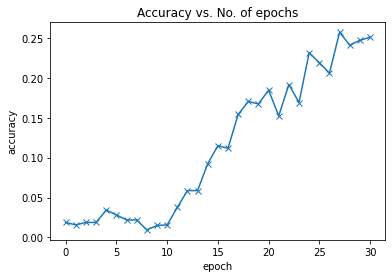

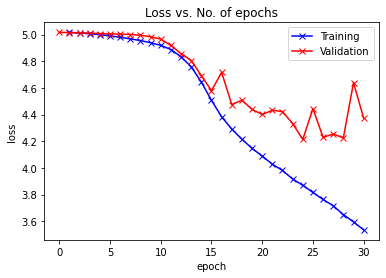


 Test Results, Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD


{'val_acc': 0.19375000894069672, 'val_loss': 4.517141819000244}

In [59]:
# Experiment Values: Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD
#Getting Model
model_baseline_SGD_epoch_30 = getModel('baseline') 

#Training Model
history_baseline_SGD_epoch_30 = trainModel(model_baseline_SGD_epoch_30, train_loader = train_loader, val_loader = val_loader, 
                              opt_func = torch.optim.SGD, epoch = 30, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_baseline_SGD_epoch_30)
plot_losses(history_baseline_SGD_epoch_30) 
print('\n Test Results, Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD')
evaluate(model_baseline_SGD_epoch_30, test_loader)

### 2. Baseline Modification 

baseline_modification
Training with optimizer = <class 'torch.optim.adam.Adam'>, lr = 0.001 and Epochs = 10


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0146, val_loss: 5.0152, val_acc: 0.0312


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.8365, val_loss: 4.7434, val_acc: 0.0556


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.5548, val_loss: 4.4961, val_acc: 0.0830


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.3035, val_loss: 4.3421, val_acc: 0.1080


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.1761, val_loss: 4.2728, val_acc: 0.1330


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.0552, val_loss: 4.1514, val_acc: 0.1642


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.9580, val_loss: 4.1065, val_acc: 0.1510


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.8628, val_loss: 4.0429, val_acc: 0.1823


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.8044, val_loss: 4.0523, val_acc: 0.2028


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.6768, val_loss: 4.0968, val_acc: 0.1986


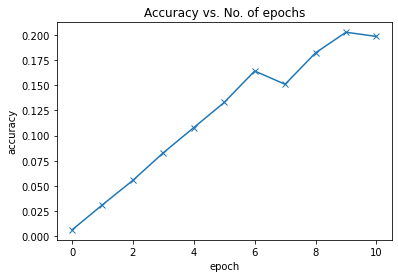

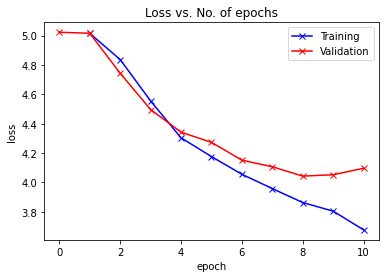


Test Results, Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam


{'val_acc': 0.20364585518836975, 'val_loss': 4.124617099761963}

In [28]:
#Experiment Values: Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam
#Getting Model
model_baseline_mod_epoch_10 = getModel('baseline_modification') 

#Training Model
history_baseline_mod_epoch_10 = trainModel(model_baseline_mod_epoch_10, train_loader = train_loader, 
                              val_loader = val_loader, opt_func = torch.optim.Adam, epoch = 10, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_baseline_mod_epoch_10)
plot_losses(history_baseline_mod_epoch_10) 
print('\nTest Results, Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam')
evaluate(model_baseline_mod_epoch_10, test_loader)

baseline_modification
Training with optimizer = <class 'torch.optim.adam.Adam'>, lr = 0.001 and Epochs = 30


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0131, val_loss: 5.0139, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.9991, val_loss: 5.0189, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.9935, val_loss: 5.0207, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.9926, val_loss: 5.0279, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9918, val_loss: 5.0186, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9907, val_loss: 5.0227, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9900, val_loss: 5.0246, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9913, val_loss: 5.0225, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9906, val_loss: 5.0229, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.9897, val_loss: 5.0241, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.9900, val_loss: 5.0200, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.9899, val_loss: 5.0241, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.9897, val_loss: 5.0198, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.9901, val_loss: 5.0226, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.9893, val_loss: 5.0225, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.9892, val_loss: 5.0239, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.9882, val_loss: 5.0254, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.9889, val_loss: 5.0225, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.9888, val_loss: 5.0232, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 4.9882, val_loss: 5.0224, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 4.9890, val_loss: 5.0217, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 4.9888, val_loss: 5.0228, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 4.9880, val_loss: 5.0251, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 4.9885, val_loss: 5.0240, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 4.9883, val_loss: 5.0254, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 4.9887, val_loss: 5.0251, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 4.9881, val_loss: 5.0252, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 4.9881, val_loss: 5.0227, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 4.9881, val_loss: 5.0242, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 4.9882, val_loss: 5.0242, val_acc: 0.0156


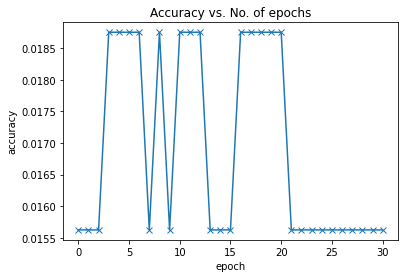

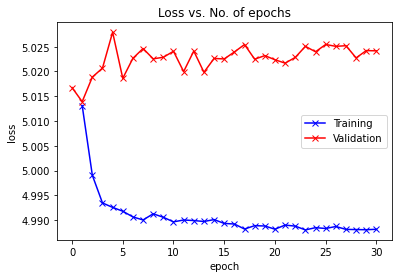


 Testing Results: Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam


{'val_acc': 0.014062500558793545, 'val_loss': 5.021880626678467}

In [29]:
#Experiment Values: Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam
#Getting Model
model_baseline_mod_epoch_30 = getModel('baseline_modification') 

#Training Model
history_baseline_mod_epoch_30 = trainModel(model_baseline_mod_epoch_30, train_loader = train_loader, 
                              val_loader = val_loader, opt_func = torch.optim.Adam, epoch = 30, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_baseline_mod_epoch_30)
plot_losses(history_baseline_mod_epoch_30) 
print('\n Testing Results: Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam')
evaluate(model_baseline_mod_epoch_30, test_loader)

baseline_modification
Training with optimizer = <class 'torch.optim.sgd.SGD'>, lr = 0.001 and Epochs = 10


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0177, val_loss: 5.0187, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 5.0174, val_loss: 5.0186, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 5.0171, val_loss: 5.0186, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 5.0170, val_loss: 5.0185, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 5.0168, val_loss: 5.0184, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 5.0165, val_loss: 5.0184, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 5.0164, val_loss: 5.0183, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 5.0162, val_loss: 5.0182, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 5.0161, val_loss: 5.0182, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 5.0158, val_loss: 5.0181, val_acc: 0.0281


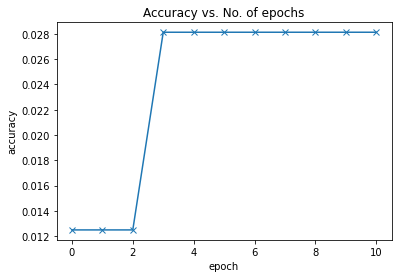

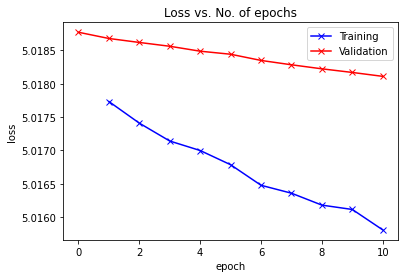


Test Results, Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam


{'val_acc': 0.0234375, 'val_loss': 5.020389080047607}

In [44]:
#Experiment Values: Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD
#Getting Model
model_baseline_mod_SGD_epoch_10 = getModel('baseline_modification') 

#Training Model
history_baseline_mod_SGD_epoch_10 = trainModel(model_baseline_mod_SGD_epoch_10, train_loader = train_loader, 
                              val_loader = val_loader, opt_func = torch.optim.SGD, epoch = 10, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_baseline_mod_SGD_epoch_10)
plot_losses(history_baseline_mod_SGD_epoch_10) 
print('\nTest Results, Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD')
evaluate(model_baseline_mod_SGD_epoch_10, test_loader)

baseline_modification
Training with optimizer = <class 'torch.optim.sgd.SGD'>, lr = 0.001 and Epochs = 30


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.9847, val_loss: 5.0243, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.9847, val_loss: 5.0244, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.9838, val_loss: 5.0246, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.9844, val_loss: 5.0247, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9844, val_loss: 5.0248, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9856, val_loss: 5.0249, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9840, val_loss: 5.0250, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9846, val_loss: 5.0251, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9846, val_loss: 5.0252, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.9845, val_loss: 5.0252, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.9844, val_loss: 5.0253, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.9840, val_loss: 5.0254, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.9837, val_loss: 5.0255, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.9845, val_loss: 5.0256, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.9844, val_loss: 5.0257, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.9844, val_loss: 5.0257, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.9845, val_loss: 5.0258, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.9854, val_loss: 5.0258, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.9845, val_loss: 5.0258, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 4.9843, val_loss: 5.0259, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 4.9838, val_loss: 5.0260, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 4.9845, val_loss: 5.0260, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 4.9844, val_loss: 5.0261, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 4.9849, val_loss: 5.0261, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 4.9847, val_loss: 5.0261, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 4.9840, val_loss: 5.0262, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 4.9839, val_loss: 5.0262, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 4.9846, val_loss: 5.0263, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 4.9839, val_loss: 5.0263, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 4.9836, val_loss: 5.0264, val_acc: 0.0156


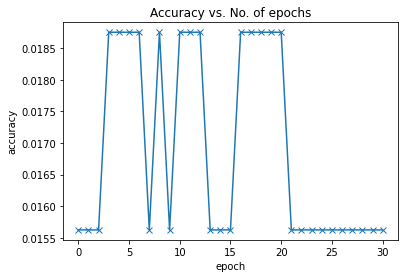

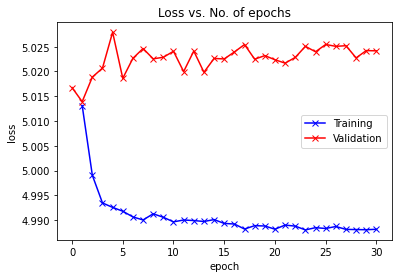


 Testing Results: Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam


{'val_acc': 0.0234375, 'val_loss': 5.016543865203857}

In [45]:
#Experiment Values: Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD
#Getting Model
model_baseline_mod_SGD_epoch_30 = getModel('baseline_modification') 

#Training Model
history_baseline_mod_SGD_epoch_30 = trainModel(model_baseline_mod_epoch_30, train_loader = train_loader, 
                              val_loader = val_loader, opt_func = torch.optim.SGD, epoch = 30, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_baseline_mod_epoch_30)
plot_losses(history_baseline_mod_epoch_30) 
print('\n Testing Results: Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD')
evaluate(model_baseline_mod_SGD_epoch_30, test_loader)

baseline_modification
Training with optimizer = <class 'torch.optim.adam.Adam'>, lr = 0.005 and Epochs = 10


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0296, val_loss: 5.0137, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.9972, val_loss: 5.0206, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.9956, val_loss: 5.0213, val_acc: 0.0250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.9930, val_loss: 5.0220, val_acc: 0.0250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9919, val_loss: 5.0180, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9922, val_loss: 5.0215, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9915, val_loss: 5.0244, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9910, val_loss: 5.0259, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9914, val_loss: 5.0264, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.9911, val_loss: 5.0258, val_acc: 0.0219


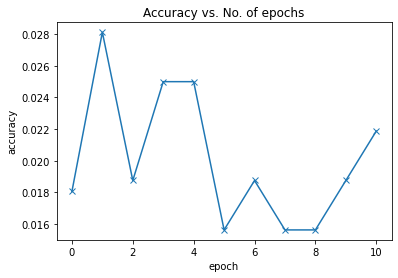

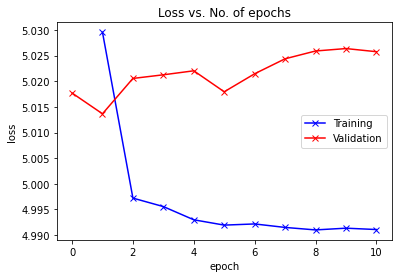


Test Results, Epoch = 10, lr = 0.005, Optimizer = torch.optim.Adam


{'val_acc': 0.015625, 'val_loss': 5.025031566619873}

In [52]:
#Experiment Values: Epoch = 10, lr = 0.005, Optimizer = torch.optim.Adam
#Getting Model
model_baseline_mod_lr_epoch_10 = getModel('baseline_modification') 

#Training Model
history_baseline_mod_lr_epoch_10 = trainModel(model_baseline_mod_lr_epoch_10, train_loader = train_loader, 
                              val_loader = val_loader, opt_func = torch.optim.Adam, epoch = 10, lr = 0.005)

#Displaying Training and Test Results
plot_accuracies(history_baseline_mod_lr_epoch_10)
plot_losses(history_baseline_mod_lr_epoch_10) 
print('\nTest Results, Epoch = 10, lr = 0.005, Optimizer = torch.optim.Adam')
evaluate(model_baseline_mod_lr_epoch_10, test_loader)

baseline_modification
Training with optimizer = <class 'torch.optim.adam.Adam'>, lr = 0.005 and Epochs = 30


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0464, val_loss: 5.0139, val_acc: 0.0219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.9985, val_loss: 5.0200, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.9945, val_loss: 5.0218, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.9935, val_loss: 5.0212, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.9927, val_loss: 5.0215, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.9921, val_loss: 5.0226, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.9926, val_loss: 5.0220, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.9909, val_loss: 5.0236, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.9910, val_loss: 5.0245, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.9903, val_loss: 5.0262, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.9910, val_loss: 5.0272, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.9905, val_loss: 5.0268, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.9904, val_loss: 5.0274, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.9910, val_loss: 5.0264, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.9908, val_loss: 5.0284, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.9910, val_loss: 5.0275, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.9916, val_loss: 5.0270, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.9913, val_loss: 5.0274, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.9904, val_loss: 5.0266, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 4.9910, val_loss: 5.0263, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 4.9916, val_loss: 5.0273, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 4.9904, val_loss: 5.0256, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 4.9911, val_loss: 5.0264, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 4.9901, val_loss: 5.0272, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 4.9908, val_loss: 5.0284, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 4.9908, val_loss: 5.0284, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 4.9909, val_loss: 5.0271, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 4.9900, val_loss: 5.0281, val_acc: 0.0188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 4.9905, val_loss: 5.0279, val_acc: 0.0125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 4.9915, val_loss: 5.0294, val_acc: 0.0125


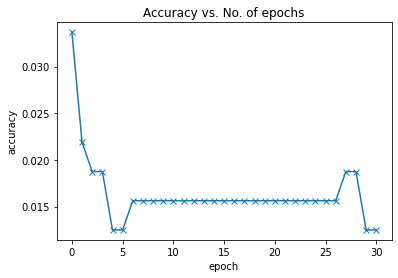

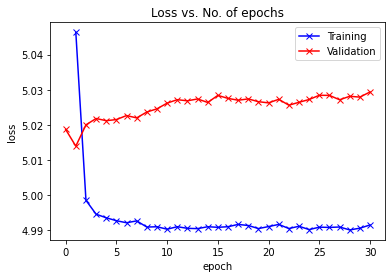


 Testing Results: Epoch = 30, lr = 0.005, Optimizer = torch.optim.Adam


{'val_acc': 0.01718750037252903, 'val_loss': 5.024093151092529}

In [53]:
#Experiment Values: Epoch = 30, lr = 0.005, Optimizer = torch.optim.Adam
#Getting Model
model_baseline_mod_lr_epoch_30 = getModel('baseline_modification') 

#Training Model
history_baseline_mod_lr_epoch_30 = trainModel(model_baseline_mod_lr_epoch_30, train_loader = train_loader, 
                              val_loader = val_loader, opt_func = torch.optim.Adam, epoch = 30, lr = 0.005)

#Displaying Training and Test Results
plot_accuracies(history_baseline_mod_lr_epoch_30)
plot_losses(history_baseline_mod_lr_epoch_30) 
print('\n Testing Results: Epoch = 30, lr = 0.005, Optimizer = torch.optim.Adam')
evaluate(model_baseline_mod_lr_epoch_30, test_loader)

### 3. Transfer Learning (ResNet18)

In [31]:
#Loading, processing and splitting Data
#Transformer
data_transformer_res_net = getTransformer('ResNet') 

#Loading and transforming Dataset
dataset_res_net =  getDataset(data_dir, data_transformer_res_net)

#Splitting Data
train_ds_res_net, val_ds_res_net, test_ds_res_net = splitDataset(dataset_res_net)

Size of training dataset : 6270
Shape of an Image is  torch.Size([3, 224, 224])


In [32]:
#Loading Data on device
train_loader_res_net, val_loader_res_net, test_loader_res_net = dataLoader(train_ds_res_net, val_ds_res_net, test_ds_res_net, batch_size = 16)
train_loader_res_net, val_loader_res_net, test_loader_res_net = loadDataOnDevice(train_loader_res_net, val_loader_res_net, test_loader_res_net)

ResNet


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Training with optimizer = <class 'torch.optim.sgd.SGD'>, lr = 0.001 and Epochs = 10


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.9798, val_loss: 4.6711, val_acc: 0.1313


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4878, val_loss: 4.1997, val_acc: 0.3125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.0669, val_loss: 3.7268, val_acc: 0.5441


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.6465, val_loss: 3.2865, val_acc: 0.6403


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.2797, val_loss: 2.9004, val_acc: 0.7215


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.9540, val_loss: 2.5706, val_acc: 0.7528


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.6726, val_loss: 2.2732, val_acc: 0.7840


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.4247, val_loss: 2.0457, val_acc: 0.8333


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.2139, val_loss: 1.8801, val_acc: 0.8365


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.0204, val_loss: 1.7235, val_acc: 0.8583


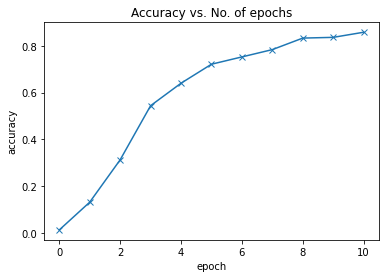

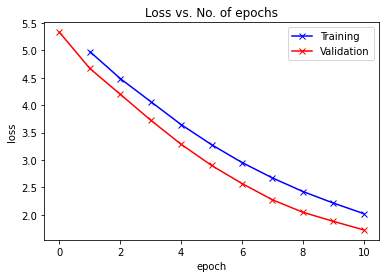


 Test Result, Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD


{'val_acc': 0.8572916984558105, 'val_loss': 1.8593775033950806}

In [33]:
#Experiment Values: Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD
#Getting Model
model_res_net_epoch_10 = getModel('ResNet') 

#Training Model
history_res_net_epoch_10 = trainModel(model_res_net_epoch_10, train_loader = train_loader_res_net, 
                             val_loader = val_loader_res_net, opt_func = torch.optim.SGD, epoch = 10, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_res_net_epoch_10)
plot_losses(history_res_net_epoch_10) 
print('\n Test Result, Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD')
evaluate(model_res_net_epoch_10, test_loader_res_net)

ResNet
Training with optimizer = <class 'torch.optim.sgd.SGD'>, lr = 0.001 and Epochs = 30


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.9716, val_loss: 4.7117, val_acc: 0.0969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.5029, val_loss: 4.2337, val_acc: 0.3649


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.0815, val_loss: 3.7445, val_acc: 0.5510


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.6777, val_loss: 3.3357, val_acc: 0.6528


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.3167, val_loss: 2.9317, val_acc: 0.7184


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.9731, val_loss: 2.5880, val_acc: 0.7521


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.6952, val_loss: 2.2701, val_acc: 0.7903


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.4456, val_loss: 2.0581, val_acc: 0.8052


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.2288, val_loss: 1.8624, val_acc: 0.8476


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.0334, val_loss: 1.7225, val_acc: 0.8632


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.8718, val_loss: 1.5189, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.7314, val_loss: 1.4334, val_acc: 0.9156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.5994, val_loss: 1.3471, val_acc: 0.9125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.4865, val_loss: 1.2347, val_acc: 0.9156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.3712, val_loss: 1.1775, val_acc: 0.9187


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.2814, val_loss: 1.0884, val_acc: 0.9313


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.2077, val_loss: 1.0390, val_acc: 0.9313


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.1153, val_loss: 0.9676, val_acc: 0.9469


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.0608, val_loss: 0.9317, val_acc: 0.9406


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.9885, val_loss: 0.9046, val_acc: 0.9344


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.9396, val_loss: 0.8548, val_acc: 0.9375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.8881, val_loss: 0.8116, val_acc: 0.9438


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.8265, val_loss: 0.8045, val_acc: 0.9375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.7869, val_loss: 0.7549, val_acc: 0.9406


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.7471, val_loss: 0.7329, val_acc: 0.9563


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.7124, val_loss: 0.7098, val_acc: 0.9563


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6748, val_loss: 0.6851, val_acc: 0.9594


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.6416, val_loss: 0.6743, val_acc: 0.9500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.6029, val_loss: 0.6468, val_acc: 0.9656


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.5715, val_loss: 0.6297, val_acc: 0.9625


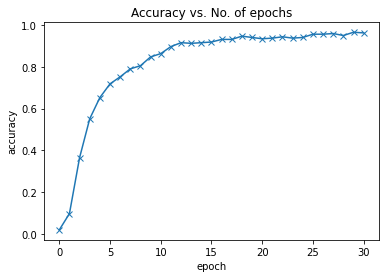

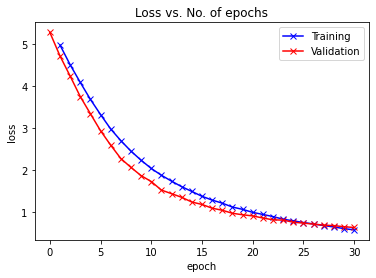


 Test Result, Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD


{'val_acc': 0.9468750357627869, 'val_loss': 0.7059946060180664}

In [54]:
#Experiment Values: Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD
#Getting Model
model_res_net_epoch_30 = getModel('ResNet') 

#Training Model
history_res_net_epoch_30 = trainModel(model_res_net_epoch_30, train_loader = train_loader_res_net, 
                             val_loader = val_loader_res_net, opt_func = torch.optim.SGD, epoch = 30, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_res_net_epoch_30)
plot_losses(history_res_net_epoch_30) 
print('\n Test Result, Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD')
evaluate(model_res_net_epoch_30, test_loader_res_net)

ResNet
Training with optimizer = <class 'torch.optim.adam.Adam'>, lr = 0.001 and Epochs = 10


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.1820, val_loss: 3.5544, val_acc: 0.3948


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.8306, val_loss: 2.8575, val_acc: 0.5503


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.9815, val_loss: 2.8629, val_acc: 0.5628


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.4043, val_loss: 1.8232, val_acc: 0.7184


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.9466, val_loss: 1.7669, val_acc: 0.7771


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5965, val_loss: 2.1825, val_acc: 0.7240


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4312, val_loss: 2.0426, val_acc: 0.7396


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.3319, val_loss: 1.7302, val_acc: 0.7983


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.3002, val_loss: 1.9429, val_acc: 0.7691


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.2337, val_loss: 1.8453, val_acc: 0.8083


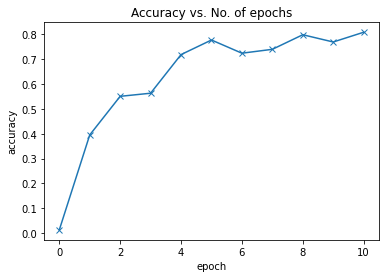

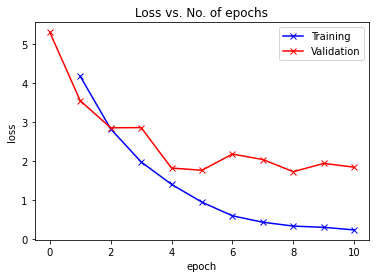


 Test Result, Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam


{'val_acc': 0.7119792103767395, 'val_loss': 2.1979475021362305}

In [49]:
#Experiment Values: Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam
#Getting Model
model_res_net_adam_epoch_10 = getModel('ResNet') 

#Training Model
history_res_net_adam_epoch_10 = trainModel(model_res_net_adam_epoch_10, train_loader = train_loader_res_net, 
                             val_loader = val_loader_res_net, opt_func = torch.optim.Adam, epoch = 10, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_res_net_adam_epoch_10)
plot_losses(history_res_net_adam_epoch_10) 
print('\n Test Result, Epoch = 10, lr = 0.001, Optimizer = torch.optim.Adam')
evaluate(model_res_net_adam_epoch_10, test_loader_res_net)

ResNet
Training with optimizer = <class 'torch.optim.adam.Adam'>, lr = 0.001 and Epochs = 30


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.1229, val_loss: 3.5708, val_acc: 0.3337


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.6629, val_loss: 2.8272, val_acc: 0.5667


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.9178, val_loss: 2.3935, val_acc: 0.6569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.3190, val_loss: 1.8567, val_acc: 0.7403


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.9506, val_loss: 1.6762, val_acc: 0.7646


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6207, val_loss: 1.7691, val_acc: 0.7733


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4096, val_loss: 1.6661, val_acc: 0.8014


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.3419, val_loss: 1.6985, val_acc: 0.7622


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2634, val_loss: 2.1224, val_acc: 0.7764


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.3107, val_loss: 1.8654, val_acc: 0.7816


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.2076, val_loss: 1.7249, val_acc: 0.7927


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1907, val_loss: 1.6116, val_acc: 0.8139


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.1673, val_loss: 1.8202, val_acc: 0.7913


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.3029, val_loss: 1.8925, val_acc: 0.7826


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1412, val_loss: 1.6361, val_acc: 0.8146


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.2012, val_loss: 2.3956, val_acc: 0.7552


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.2017, val_loss: 1.9464, val_acc: 0.7694


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.1650, val_loss: 1.9761, val_acc: 0.7757


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.1266, val_loss: 1.9404, val_acc: 0.7694


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.1087, val_loss: 1.8253, val_acc: 0.8188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.0709, val_loss: 2.3653, val_acc: 0.7451


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.1767, val_loss: 2.5382, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.1025, val_loss: 2.7424, val_acc: 0.7233


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.1662, val_loss: 2.3819, val_acc: 0.7514


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0881, val_loss: 1.8066, val_acc: 0.7951


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.0777, val_loss: 2.3013, val_acc: 0.7389


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.2038, val_loss: 2.3975, val_acc: 0.7764


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0929, val_loss: 2.3101, val_acc: 0.7757


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.1916, val_loss: 2.6803, val_acc: 0.7465


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.1295, val_loss: 2.3363, val_acc: 0.7444


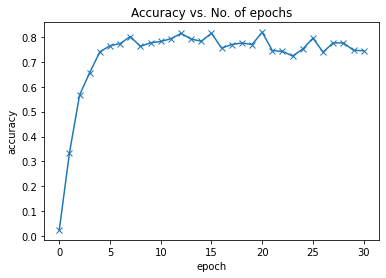

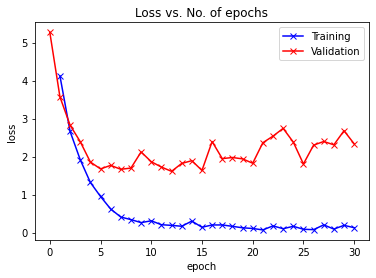


 Test Result, Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam


{'val_acc': 0.7244791984558105, 'val_loss': 2.883868455886841}

In [50]:
#Experiment Values: Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam
#Getting Model
model_res_net_adam_epoch_30 = getModel('ResNet') 

#Training Model
history_res_net_adam_epoch_30 = trainModel(model_res_net_adam_epoch_30, train_loader = train_loader_res_net, 
                             val_loader = val_loader_res_net, opt_func = torch.optim.Adam, epoch = 30, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_res_net_adam_epoch_30)
plot_losses(history_res_net_adam_epoch_30) 
print('\n Test Result, Epoch = 30, lr = 0.001, Optimizer = torch.optim.Adam')
evaluate(model_res_net_adam_epoch_30, test_loader_res_net)

ResNet
Training with optimizer = <class 'torch.optim.sgd.SGD'>, lr = 0.001 and Epochs = 10


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0428, val_loss: 4.9680, val_acc: 0.0469


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.9472, val_loss: 4.8611, val_acc: 0.0656


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.8805, val_loss: 4.7739, val_acc: 0.0781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.8195, val_loss: 4.7155, val_acc: 0.1000


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.7669, val_loss: 4.6378, val_acc: 0.1344


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.7063, val_loss: 4.6152, val_acc: 0.1500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.6512, val_loss: 4.5351, val_acc: 0.1313


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.6024, val_loss: 4.4940, val_acc: 0.1594


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.5511, val_loss: 4.4527, val_acc: 0.1813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.4992, val_loss: 4.4009, val_acc: 0.1875


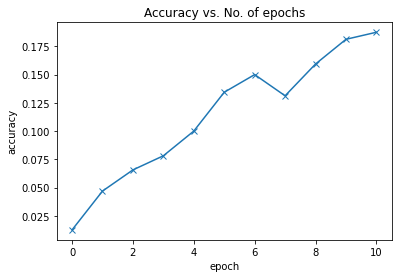

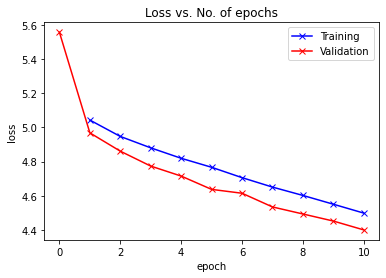


 Test Result, Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD


{'val_acc': 0.14374999701976776, 'val_loss': 4.500899314880371}

In [35]:
#Experiment: Transfer Learning without pretrained weight
#Values: Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD
#Getting Model
model_res_net_no_pretrained_epoch_10 = getModel('ResNet',preTrained = False)

#Training Model
history_res_net_epoch_no_pretrained_10 = trainModel(model_res_net_no_pretrained_epoch_10, train_loader = train_loader_res_net, 
                             val_loader = val_loader_res_net, opt_func = torch.optim.SGD, epoch = 10, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_res_net_epoch_no_pretrained_10)
plot_losses(history_res_net_epoch_no_pretrained_10) 
print('\n Test Result, Epoch = 10, lr = 0.001, Optimizer = torch.optim.SGD')
evaluate(model_res_net_no_pretrained_epoch_10, test_loader_res_net)

ResNet
Training with optimizer = <class 'torch.optim.sgd.SGD'>, lr = 0.001 and Epochs = 30


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0380, val_loss: 4.9537, val_acc: 0.0594


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.9185, val_loss: 4.8447, val_acc: 0.0844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.8373, val_loss: 4.7500, val_acc: 0.1031


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.7724, val_loss: 4.7083, val_acc: 0.1281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.7113, val_loss: 4.6058, val_acc: 0.1375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.6620, val_loss: 4.5598, val_acc: 0.1313


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.6104, val_loss: 4.5020, val_acc: 0.1500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.5691, val_loss: 4.4509, val_acc: 0.1688


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.5112, val_loss: 4.4107, val_acc: 0.1875


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.4664, val_loss: 4.3338, val_acc: 0.2000


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 4.4175, val_loss: 4.2861, val_acc: 0.2031


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 4.3663, val_loss: 4.2452, val_acc: 0.2125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 4.3131, val_loss: 4.1761, val_acc: 0.2125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 4.2720, val_loss: 4.1235, val_acc: 0.2281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 4.2332, val_loss: 4.0724, val_acc: 0.2712


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 4.1855, val_loss: 4.0629, val_acc: 0.2681


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 4.1561, val_loss: 3.9900, val_acc: 0.2993


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 4.0949, val_loss: 3.9770, val_acc: 0.2924


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 4.0663, val_loss: 4.0037, val_acc: 0.2736


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 4.0355, val_loss: 3.9048, val_acc: 0.3024


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 4.0013, val_loss: 3.8764, val_acc: 0.3274


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 3.9715, val_loss: 3.8338, val_acc: 0.2931


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 3.9369, val_loss: 3.7838, val_acc: 0.3274


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 3.8911, val_loss: 3.7821, val_acc: 0.3274


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 3.8666, val_loss: 3.7840, val_acc: 0.3299


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 3.8392, val_loss: 3.7835, val_acc: 0.3299


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 3.8167, val_loss: 3.6854, val_acc: 0.3431


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 3.7965, val_loss: 3.6766, val_acc: 0.3424


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 3.7646, val_loss: 3.6490, val_acc: 0.3493


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 3.7425, val_loss: 3.6624, val_acc: 0.3618


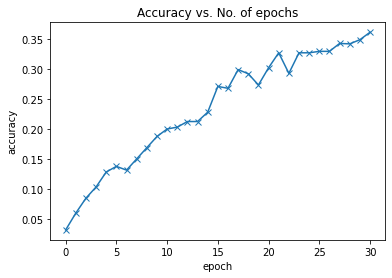

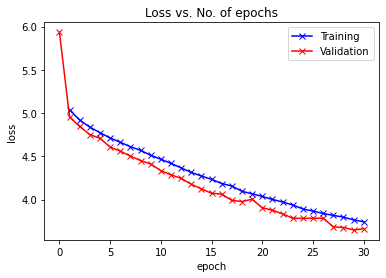


 Test Result, Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD


{'val_acc': 0.3046875, 'val_loss': 3.845060110092163}

In [36]:
#Experiment: Transfer Learning without pretrained weight
#Experiment Values: Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD
#Getting Model
model_res_net_no_pretrained_epoch_30 = getModel('ResNet', preTrained = False)

#Training Model
history_res_net_no_pretrained_epoch_30 = trainModel(model_res_net_no_pretrained_epoch_30, train_loader = train_loader_res_net, 
                             val_loader = val_loader_res_net, opt_func = torch.optim.SGD, epoch = 30, lr = 0.001)

#Displaying Training and Test Results
plot_accuracies(history_res_net_no_pretrained_epoch_30)
plot_losses(history_res_net_no_pretrained_epoch_30) 
print('\n Test Result, Epoch = 30, lr = 0.001, Optimizer = torch.optim.SGD')
evaluate(model_res_net_no_pretrained_epoch_30, test_loader_res_net)

##FLOPs

In [37]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

--2022-08-15 08:59:06--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=bja75paaa8f9dee9q8d7eu44e7; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=bToRID2ihRsou9eVVwJ5mwM9caDDTSgop9GyihsA1BxYS0Kevo2Wjc71cgsz6sOr%2FCqlw9d6lfZqqxFrk3WXJk8meg9fUNY4nj8x2a9W52U86%2BcvsejfCWKBDcexEyv4; expires=Tue, 16-Aug-2022 08:59:06 GMT; Max-Age=86400; path=/plus;; Secure at position 220.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-08-15 08:59:07 (595 MB/s) - ‘download’ saved [5201/5201]



In [38]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151

print('Transfer Learning(ResNet)')
model_tl = ResNetPreTrainedNetwork(num_classes)
print_model_parm_flops(model_tl, input)

Transfer Learning(ResNet)
 + Number of FLOPs: 0.96G
